# Network inference of categorical variables: non-sequential data

In [1]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import inference
import fem

In [2]:
# setting parameter:
np.random.seed(1)

n = 20 # number of positions
m = 3 # number of values at each position
l = int(((n*m)**2)) # number of samples
g = 2.

nm = n*m

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

In [4]:
# generate coupling matrix w0:
def generate_interactions(n,m,g):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    i1tab,i2tab = itab(n,m)

    for i in range(n):        
        i1,i2 = i1tab[i],i2tab[i]              
        w[i1:i2,:] -= w[i1:i2,:].mean(axis=0)            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,i1:i2] = 0.   # no self-interactions

    for i in range(nm):
        for j in range(nm):
            if j > i: w[i,j] = w[j,i]  
        
    return w

In [5]:
w0 = inference.generate_interactions(n,m,g)

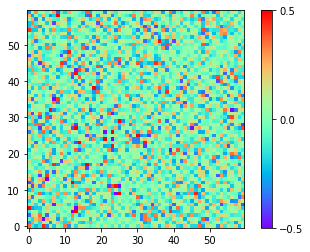

In [6]:
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])
plt.show()
#print(w0)

In [7]:
def generate_sequences_old(w,n,m,l): 

    i1tab,i2tab = itab(n,m)    

    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 2*m
    nrepeat = 10*n*m

    for t in range(l):
        for irepeat in range(nrepeat):            # update for entire positions
            for i in range(n):
                i1,i2 = i1tab[i],i2tab[i]

                h = np.sum(s[t,:]*w[i1:i2,:],axis=1)  # h[i1:i2]

                k = np.random.randint(0,m)              
                for itrial in range(ntrial):     # update at each position           
                    k2 = np.random.randint(0,m)                
                    while k2 == k:
                        k2 = np.random.randint(0,m)

                    if np.exp(h[k2]- h[k]) > np.random.rand():
                        k = k2

                s[t,i1:i2] = 0.
                s[t,i1+k] = 1.
            
    return s 

In [8]:
def generate_sequences(w,n,m,l):
    i1tab,i2tab = itab(n,m)

    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    print(s)

    nrepeat = 1000
    for irepeat in range(nrepeat):
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]

            h = s.dot(w[i1:i2,:].T)              # h[t,i1:i2]
            h_old = (s[:,i1:i2]*h).sum(axis=1)   # h[t,i0]
            k = np.random.randint(0,m,size=l)

            for t in range(l):
                if np.exp(h[t,k[t]] - h_old[t]) > np.random.rand():
                    s[t,i1:i2] = 0.
                    s[t,i1+k[t]] = 1.
    return s                

In [9]:
s = generate_sequences(w0,n,m,l)

[[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]]


In [10]:
print(s.shape)

(3600, 60)


In [11]:
s_inverse = np.argmax(s.reshape(-1,m),axis=1).reshape(-1,n)

print(s_inverse.shape)

y = (s_inverse.T).copy()
print(y.shape)

model = fem.discrete.model()
x1, x2 = y[:, :-1], y[:, 1:]
model.fit(x1, x2)

(3600, 20)
(20, 3600)


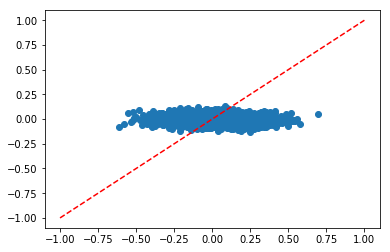

In [12]:
w_fit_flat = np.hstack([wi for wi in model.w.itervalues()]).flatten()

plt.scatter(w0,w_fit_flat.reshape(nm,nm))
plt.plot([-1.0,1.0],[-1.0,1.0],'r--')
plt.show()

In [13]:
i1tab,i2tab = itab(n,m) 

nloop = 10
nm1 = nm - m

wini = np.random.normal(0.0,1./np.sqrt(nm),size=(nm,nm1))

i = 0

i1,i2 = i1tab[i],i2tab[i]

#x = np.hstack([s[:,:i1],s[:,i2:]])
x = s[:,i2:].copy()
y = s.copy()

# covariance[ia,ib]
cab_inv = np.empty((m,m,nm1,nm1))
eps = np.empty((m,m,l))
for ia in range(m):
    for ib in range(m):
        if ib != ia:
            eps[ia,ib,:] = y[:,i1+ia] - y[:,i1+ib]
            
            which_ab = eps[ia,ib,:] !=0.                    
            xab = x[which_ab]          

            # ----------------------------
            xab_av = np.mean(xab,axis=0)
            dxab = xab - xab_av
            cab = np.cov(dxab,rowvar=False,bias=True)
            cab_inv[ia,ib,:,:] = linalg.pinv(cab,rcond=1e-15)


w = wini[i1:i2,:].copy()            
for iloop in range(nloop):
    h = np.dot(x,w.T)
    
    for ia in range(m):
        wa = np.zeros(nm1)
        for ib in range(m):
            if ib != ia:

                which_ab = eps[ia,ib,:] !=0.

                eps_ab = eps[ia,ib,which_ab]
                xab = x[which_ab]

                # ----------------------------
                xab_av = np.mean(xab,axis=0)
                dxab = xab - xab_av

                h_ab = h[which_ab,ia] - h[which_ab,ib]                    
                ha = np.divide(eps_ab*h_ab,np.tanh(h_ab/2.), out=np.zeros_like(h_ab), where=h_ab!=0)                        

                dhdx = (ha - ha.mean())[:,np.newaxis]*dxab
                dhdx_av = dhdx.mean(axis=0)

                wab = cab_inv[ia,ib,:,:].dot(dhdx_av) # wa - wb

                wa += wab
        w[ia,:] = wa/m

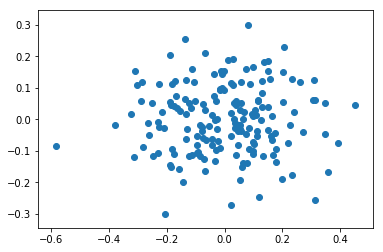

In [14]:
plt.scatter(w0[i1:i2,i2:],w)